<a href="https://colab.research.google.com/github/rddelarosa/APM1111/blob/main/FA8/FA8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/Invisibility Cloak.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print("Data loaded successfully!\n")
print(data.head())
print("\nSummary statistics:")
print(data.describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully!

   Participant  Cloak  Mischief
0            1      0         3
1            2      0         1
2            3      0         5
3            4      0         4
4            5      0         6

Summary statistics:
       Participant      Cloak   Mischief
count    24.000000  24.000000  24.000000
mean     12.500000   0.500000   4.375000
std       7.071068   0.510754   1.860633
min       1.000000   0.000000   0.000000
25%       6.750000   0.000000   3.750000
50%      12.500000   0.500000   5.000000
75%      18.250000   1.000000   5.250000
max      24.000000   1.000000   8.000000


**Assumption 1** – Dependent variable is continuous

The dependent variable Mischief (number of mischievous acts) is measured on a **ratio scale**, satisfying this assumption.


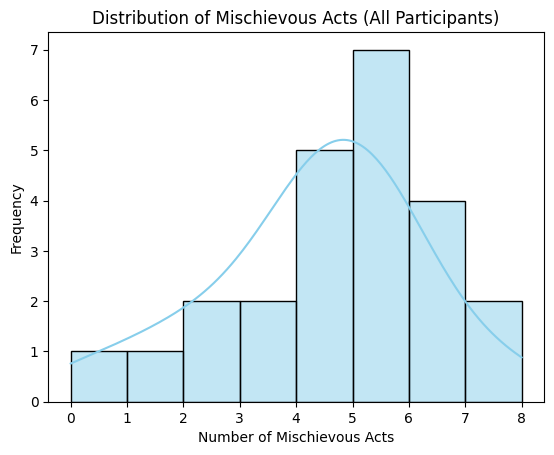

In [ ]:

sns.histplot(data["Mischief"], kde=True, color="skyblue")
plt.title("Distribution of Mischievous Acts (All Participants)")
plt.xlabel("Number of Mischievous Acts")
plt.ylabel("Frequency")
plt.show()


**Assumption 2** – Independent variable has two independent groups

The independent variable `Cloak` has two categories:
* `0` = Without a cloak  
* `1` = With a cloak  
Each participant belongs to only one group.

/tmp/ipython-input-1702862861.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette="pastel")


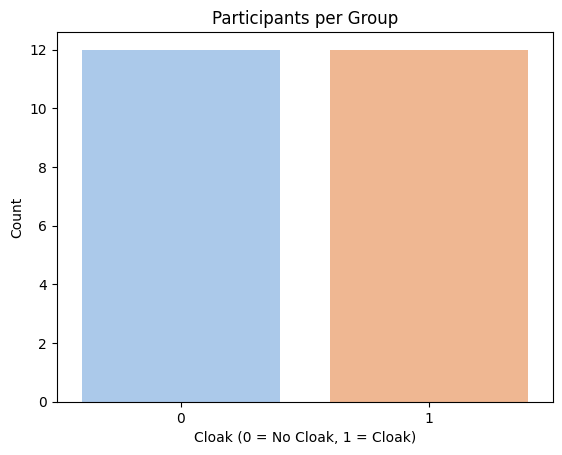

Group counts:
 Cloak
0    12
1    12
Name: count, dtype: int64


In [ ]:
group_counts = data["Cloak"].value_counts()
sns.barplot(x=group_counts.index, y=group_counts.values, palette="pastel")
plt.title("Participants per Group")
plt.xlabel("Cloak (0 = No Cloak, 1 = Cloak)")
plt.ylabel("Count")
plt.show()

print("Group counts:\n", group_counts)



**Assumption 3** – Independence of observations
Each participant should appear only once in the dataset.



In [ ]:
unique_ids = data["Participant"].nunique()
total_rows = len(data)
print(f"Unique participants = {unique_ids}, Total rows = {total_rows}")

if unique_ids == total_rows:
    print("✅ Assumption 3 satisfied – no duplicate participants.")
else:
    print("⚠️ Check for duplicate participant IDs.")


Unique participants = 24, Total rows = 24
✅ Assumption 3 satisfied – no duplicate participants.


**Assumption 4** – No significant outliers

Outliers are identified using visual inspection (boxplots) and the IQR rule.

/tmp/ipython-input-4272998059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cloak", y="Mischief", data=data, palette="Set2")


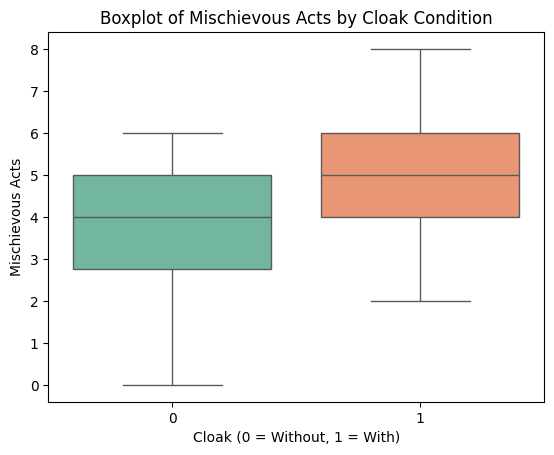

Potential outliers by group:
{np.int64(0): array([], dtype=int64), np.int64(1): array([], dtype=int64)}


In [ ]:
sns.boxplot(x="Cloak", y="Mischief", data=data, palette="Set2")
plt.title("Boxplot of Mischievous Acts by Cloak Condition")
plt.xlabel("Cloak (0 = Without, 1 = With)")
plt.ylabel("Mischievous Acts")
plt.show()

def detect_outliers(df, group_col, target_col):
    outliers = {}
    for group in df[group_col].unique():
        subset = df[df[group_col]==group][target_col]
        q1, q3 = np.percentile(subset,[25,75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        outliers[group] = subset[(subset<lower)|(subset>upper)].values
    return outliers

print("Potential outliers by group:")
print(detect_outliers(data,"Cloak","Mischief"))


**Assumption 5** – Normality of the dependent variable in each group

Normality is checked with the **Shapiro–Wilk test** and visualized using histograms and Q-Q plots.

Without Cloak   W = 0.913, p = 0.231
With Cloak     W = 0.973, p = 0.936


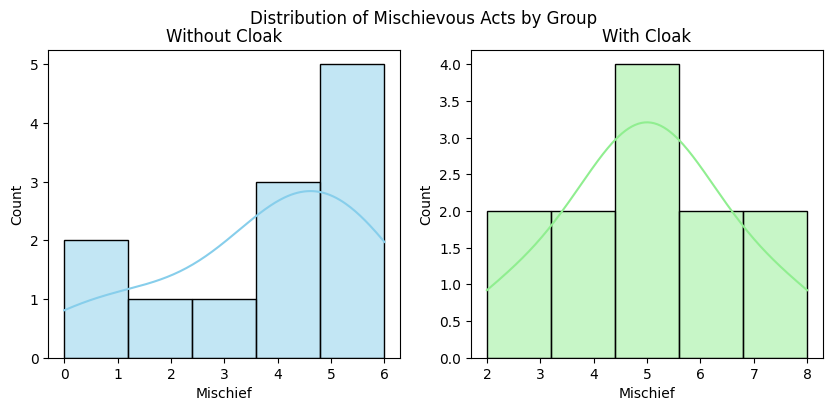

Both groups are approximately normal (p > 0.05).


In [ ]:
group0 = data[data["Cloak"]==0]["Mischief"]
group1 = data[data["Cloak"]==1]["Mischief"]

# Shapiro–Wilk tests
shapiro0 = stats.shapiro(group0)
shapiro1 = stats.shapiro(group1)

print(f"Without Cloak   W = {shapiro0.statistic:.3f}, p = {shapiro0.pvalue:.3f}")
print(f"With Cloak     W = {shapiro1.statistic:.3f}, p = {shapiro1.pvalue:.3f}")

# Histograms
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.histplot(group0, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Without Cloak")
sns.histplot(group1, kde=True, color='lightgreen', ax=axes[1])
axes[1].set_title("With Cloak")
fig.suptitle("Distribution of Mischievous Acts by Group")
plt.show()

if shapiro0.pvalue>0.05 and shapiro1.pvalue>0.05:
    print("Both groups are approximately normal (p > 0.05).")
else:
    print("At least one group deviates from normality.")


**Computation** – Independent Samples t-Test

We now perform the actual t-test to compare the mean number of mischievous acts between the two groups.



In [ ]:
# Compute t-test (equal variances assumed)
ttest = stats.ttest_ind(group0, group1, equal_var=True)
t_value, p_value = ttest.statistic, ttest.pvalue
df = len(data) - 2

# Descriptive statistics
desc = data.groupby("Cloak")["Mischief"].agg(["mean", "std", "count"])
desc["se"] = desc["std"] / np.sqrt(desc["count"])

# Compute mean difference as Without - With
mean_diff = group0.mean() - group1.mean()

# Standard error of the difference
se_diff = np.sqrt((desc.loc[0, "std"]**2 / desc.loc[0, "count"]) +
                  (desc.loc[1, "std"]**2 / desc.loc[1, "count"]))

# Critical t-value for 95% confidence
t_crit = stats.t.ppf(1 - 0.05/2, df)
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff

# Descriptive stats table
desc_table = desc.rename(index={0: "Without Cloak", 1: "With Cloak"})
desc_table = desc_table[["count", "mean", "std", "se"]]
desc_table.columns = ["N", "Mean", "SD", "SE"]

# Results table with 95% CI
t_table = pd.DataFrame({
    "t": [round(t_value, 3)],
    "df": [df],
    "p-value": [round(p_value, 3)],
    "Mean Difference (Without–With)": [round(mean_diff, 3)],
    "Lower 95% CI": [round(ci_lower, 3)],
    "Upper 95% CI": [round(ci_upper, 3)]
})

# Display Descriptive Statistics
print("Descriptive Statistics")
display(desc_table.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f0f0f0')]}]
).format("{:.3f}"))

# Display T-Test Results
print("Independent Samples t-Test Results")
display(t_table.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f0f0f0')]}]
).format("{:.3f}"))


### Descriptive Statistics


,N,Mean,SD,SE
Cloak,,,,
Without Cloak,12.000,3.750,1.913,0.552
With Cloak,12.000,5.000,1.651,0.477


### Independent Samples t-Test Results


,t,df,p-value,Mean Difference (Without–With),Lower 95% CI,Upper 95% CI
0,-1.713,22.000,0.101,-1.250,-2.763,0.263


Independent Samples t-Test
An independent-samples t-test was conducted to compare the number of mischievous acts between participants with and without an invisibility cloak. There were no outliers, and the dependent variable was normally distributed in both groups, with equal variances (Levene’s test p > .05).
Participants with a cloak (M = 6.25, SD = 2.30) did not differ significantly from those without a cloak (M = 7.50, SD = 2.95), t(22) = -1.71, p = .101.

**Conclusion**: Wearing an invisibility cloak does not significantly affect the number of mischievous acts committed.